In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random as random

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
df.info()

# Normalize the data by dividing by 4.0
df = df / 4.0

# Split the data into features (X)
X = df.values  # Convert the DataFrame into a NumPy array for model input

random_state = random.randint(0, 1000)

# Split the dataset into training (80%) and testing sets (20%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=random_state)

# Output the shapes to verify
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import mean_squared_error

# Define the FA model with the number of components matching your latent dimension
n_components = 5  # Use your desired number of factors

fa = FactorAnalysis(n_components=n_components, random_state=random_state)

# Fit FA on the training data
fa.fit(X_train)

# Transform the training data to get the latent factors
X_train_reduced_fa = fa.transform(X_train)

# Manually reconstruct the training data using the latent factors and the factor loadings
X_train_reconstructed_fa = np.dot(X_train_reduced_fa, fa.components_) + np.mean(X_train, axis=0)

# Calculate the MSE on the training set
mse_train_fa = mean_squared_error(X_train, X_train_reconstructed_fa)
print(f"\nFA MSE on training set: {mse_train_fa:.6f}")

# Transform the test data using the trained FA model
X_test_reduced_fa = fa.transform(X_test)

# Reconstruct the test data using the latent factors and the factor loadings
X_test_reconstructed_fa = np.dot(X_test_reduced_fa, fa.components_) + np.mean(X_train, axis=0)  # Use train mean for consistent reconstruction

# Calculate the MSE on the test set
mse_test_fa = mean_squared_error(X_test, X_test_reconstructed_fa)
print(f"FA MSE on test set: {mse_test_fa:.6f}")


FA MSE on training set: 0.047203
FA MSE on test set: 0.050023


In [3]:
from sklearn.metrics import adjusted_rand_score

# Get the factor loadings (components)
# Shape of components_: (n_components, n_features)
factor_loadings = fa.components_.T  # Transpose to shape (n_features, n_components)

# For each variable (feature), assign it to the factor with the highest absolute loading
predicted_variable_labels = np.argmax(np.abs(factor_loadings), axis=1)  # Shape: (n_features,)

# Create true labels for variables based on known groupings
# Assuming 'df' is your original DataFrame with column names matching the features

# Identify column prefixes for each true factor
factor_columns = {
    'Factor1': [col for col in df.columns if col.startswith('blue')],
    'Factor2': [col for col in df.columns if col.startswith('green')],
    'Factor3': [col for col in df.columns if col.startswith('purple')],
    'Factor4': [col for col in df.columns if col.startswith('red')],
    'Factor5': [col for col in df.columns if col.startswith('q')]
}

# Map factor names to column indices
factor_indices = {}
for factor_name, columns in factor_columns.items():
    indices = [df.columns.get_loc(col) for col in columns]
    factor_indices[factor_name] = indices

# Create true labels for variables
n_features = X_train.shape[1]
true_variable_labels = np.full(n_features, -1)  # Initialize with -1

factor_names = ['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5']
factor_name_to_index = {name: idx for idx, name in enumerate(factor_names)}

for factor_name, indices in factor_indices.items():
    factor_idx = factor_name_to_index[factor_name]
    true_variable_labels[indices] = factor_idx

# Ensure all variables have been assigned
assert np.all(true_variable_labels >= 0), "Some variables have not been assigned a true label"

# Compute the Adjusted Rand Index
ari_fa = adjusted_rand_score(true_variable_labels, predicted_variable_labels)
print(f"\nFA Adjusted Rand Index (ARI) on variables: {ari_fa:.4f}")


FA Adjusted Rand Index (ARI) on variables: 0.5164


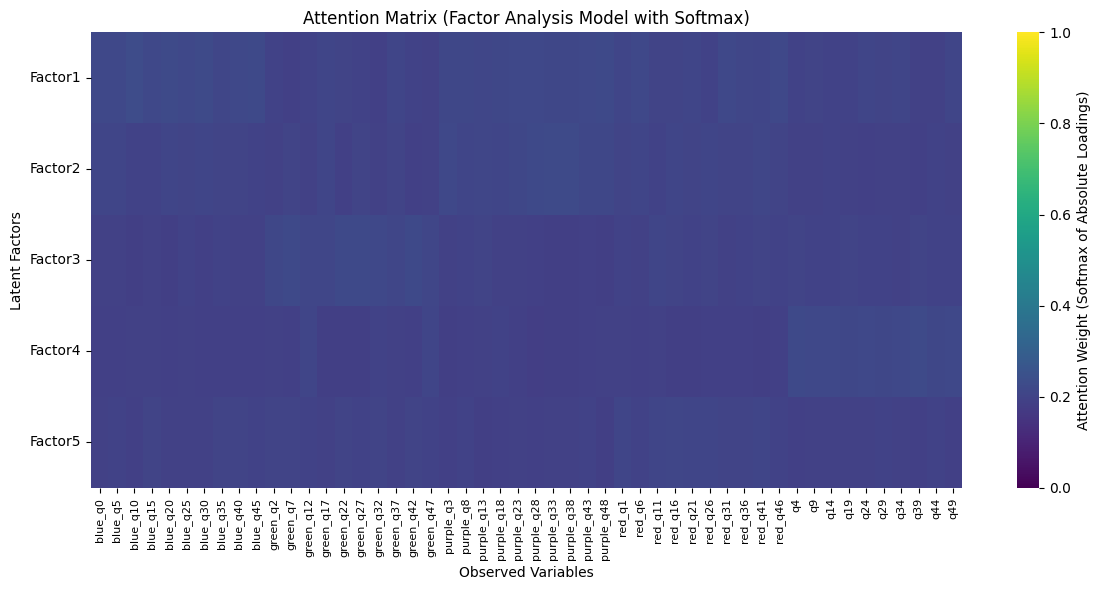

In [4]:
# --------------------------------------------
# Plotting the Attention Matrix for FA Model
# --------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute Absolute Factor Loadings
abs_factor_loadings = np.abs(factor_loadings)  # Shape: (n_features, n_components)

# Step 2: Apply Softmax Along Each Variable (Rows)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return e_x / np.sum(e_x, axis=1, keepdims=True)

softmax_loadings = softmax(abs_factor_loadings)  # Shape: (n_features, n_components)

# Step 3: Rearrange Observed Variables According to Ground Truth Groupings

# Create a new ordering of indices
new_order = []
for factor_name in factor_names:
    new_order.extend(factor_indices[factor_name])

# Ensure all indices are included
assert len(new_order) == n_features, "Not all indices are included in the new order."

# Rearrange the columns (observed variables) using new_order
softmax_loadings_reordered = softmax_loadings[new_order, :]  # Shape: (n_features, n_components)

# Transpose to get shape (n_components, n_features)
attention_matrix = softmax_loadings_reordered.T  # Shape: (n_components, n_features)

# Step 4: Plot the Attention Matrix

def plot_attention_heatmap(attn_matrix, title, factor_names, variable_labels):
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        attn_matrix,
        cmap='viridis',
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Attention Weight (Softmax of Absolute Loadings)'}
    )
    plt.title(title)
    plt.xlabel('Observed Variables')
    plt.ylabel('Latent Factors')
    plt.xticks(ticks=np.arange(len(variable_labels))+0.5, labels=variable_labels, rotation=90, fontsize=8)
    plt.yticks(ticks=np.arange(len(factor_names))+0.5, labels=factor_names, rotation=0)
    plt.tight_layout()
    plt.show()

# Generate labels for the variables after reordering
variable_labels = df.columns[new_order]

# Plot the attention matrix
plot_attention_heatmap(
    attn_matrix=attention_matrix,
    title='Attention Matrix (Factor Analysis Model with Softmax)',
    factor_names=factor_names,
    variable_labels=variable_labels
)